In [1]:
from src.anchors import AnchorGenerator
import torch
import matplotlib.cm as cmx
import matplotlib.colors as mcolors
from cycler import cycler
import matplotlib.pyplot as plt
from matplotlib import patheffects, patches
%load_ext autoreload
%autoreload 2
########################################## 
# Utilities to visualize `anchor` boxes 
###########################################
def get_cmap(N):
    color_norm  = mcolors.Normalize(vmin=0, vmax=N-1)
    return cmx.ScalarMappable(norm=color_norm, cmap='Set3').to_rgba

def draw_rect(ax, b, color='white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 4)
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, b, color='white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 4)

def draw_text(ax, xy, txt, sz=14, color='white'):
    text = ax.text(*xy, txt,
        verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 1)

def show_boxes(boxes, ax=None):
    "Show the `boxes` (size by 4)"
    if ax is None:
        _, ax = plt.subplots(1,1, figsize=(6,6))
        ax.set_xlim(-500,500)
        ax.set_ylim(500,-500)
    for i, bbox in enumerate(boxes):
        bb = bbox.numpy()
        rect = [ bb[0], bb[1], bb[2]-bb[0],  bb[3]-bb[1]] 
        draw_rect(ax, rect, color=color_list[i%num_color])
        draw_text(ax, [bb[0], bb[1]], str(i), color=color_list[i%num_color])
    return ax
###################################################################################################################

num_color = 12
cmap = get_cmap(num_color)
color_list = [cmap(float(x)) for x in range(num_color)]

In [2]:
anchor_generator = AnchorGenerator()
# Generate anchors on feature maps of sizes [1, 2, 4, 8, 16]
feature_maps = [torch.randn((1, 15, 2**i,2**i)) for i in range(5)]
images = torch.rand([2, 3, 600, 600])
anchors = anchor_generator(images, feature_maps)

In [7]:
for i, anc in enumerate(anchors):
    print(f"Anchor for Image {i+1}:\n", anc)
    print('\n')

Anchor for Image 1:
 tensor([[ -22.6274,  -11.3137,   22.6274,   11.3137],
        [ -16.0000,  -16.0000,   16.0000,   16.0000],
        [ -11.3137,  -22.6274,   11.3137,   22.6274],
        ...,
        [1345.2994, 1632.6497, 2494.7007, 2207.3503],
        [1513.6254, 1513.6254, 2326.3748, 2326.3748],
        [1632.6497, 1345.2994, 2207.3503, 2494.7007]])


Anchor for Image 2:
 tensor([[ -22.6274,  -11.3137,   22.6274,   11.3137],
        [ -16.0000,  -16.0000,   16.0000,   16.0000],
        [ -11.3137,  -22.6274,   11.3137,   22.6274],
        ...,
        [1345.2994, 1632.6497, 2494.7007, 2207.3503],
        [1513.6254, 1513.6254, 2326.3748, 2326.3748],
        [1632.6497, 1345.2994, 2207.3503, 2494.7007]])




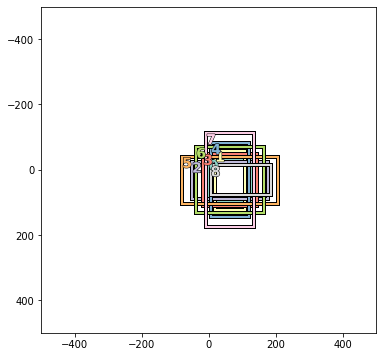

In [8]:
# Plot anchor boxes
show_boxes(anchors[0][100:109])

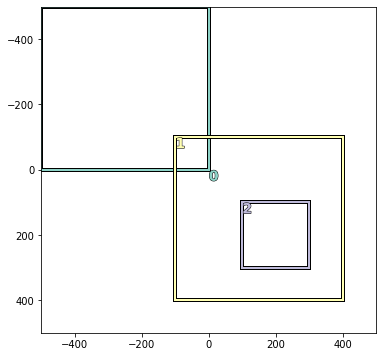

In [9]:
# Arbitary targets
targets = torch.tensor([[0., 0., -500., -500.], [-100.,-100., 400., 400.], [ 100., 100., 300., 300.]])
ax = show_boxes(targets)

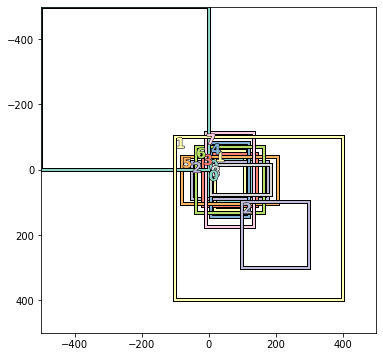

In [13]:
# Plot targets & anchor boxes tegother
ax = show_boxes(anchors[0][100:109])
_ = show_boxes(targets, ax)

In [14]:
# Calculate IOU of Boxes
from torchvision.ops.boxes import box_iou
iou = box_iou(anchors[0], targets)
print(iou)

tensor([[0.0000, 0.0041, 0.0000],
        [0.0000, 0.0041, 0.0000],
        [0.0000, 0.0041, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000]])


In [15]:
print(anchors[0].shape, iou.shape, targets.shape)

torch.Size([3069, 4]) torch.Size([3069, 3]) torch.Size([3, 4])


In [21]:
def match_anchors(anchors, targets, match_thr=0.5, bkg_thr=0.4):
    "Match `anchors` to targets. -1 is match to background, -2 is ignore."
    matches = anchors.new(anchors.size(0)).zero_().long() - 2
    if targets.numel() == 0: return matches
    ious = box_iou(anchors, targets)
    vals,idxs = torch.max(ious,1)
    matches[vals < bkg_thr] = -1
    matches[vals > match_thr] = idxs[vals > match_thr]
    return matches

# Comput matches
# match anchor with target to get proposals for background, ignore & foreground
matches = match_anchors(anchors[0], targets)

In [24]:
matches, matches >=0

(tensor([-1, -1, -1,  ..., -1, -1, -1]),
 tensor([False, False, False,  ..., False, False, False]))

In [22]:
# Create mask for anchors greater than 0
mask = matches >= 0
# anchors with mask >= 0 
anchors[0][mask].shape

torch.Size([53, 4])

In [18]:
anchors[0][mask]

tensor([[-159.3503,  -79.6751,  415.3503,  207.6751],
        [ -75.1873, -139.1873,  331.1873,  267.1873],
        [ -95.3503,  -79.6751,  479.3503,  207.6751],
        [ -11.1873, -139.1873,  395.1873,  267.1873],
        [-139.1873,  -75.1873,  267.1873,  331.1873],
        [ -79.6751, -159.3503,  207.6751,  415.3503],
        [-159.3503,  -15.6751,  415.3503,  271.6751],
        [ -75.1873,  -75.1873,  331.1873,  331.1873],
        [ -15.6751, -159.3503,  271.6751,  415.3503],
        [ 101.4903,  -53.0193,  282.5097,  309.0193],
        [ -95.3503,  -15.6751,  479.3503,  271.6751],
        [ -11.1873,  -75.1873,  395.1873,  331.1873],
        [  48.3249, -159.3503,  335.6751,  415.3503],
        [  52.8127,  -75.1873,  459.1873,  331.1873],
        [ 112.3249, -159.3503,  399.6751,  415.3503],
        [-139.1873,  -11.1873,  267.1873,  395.1873],
        [ -79.6751,  -95.3503,  207.6751,  479.3503],
        [ -53.0193,  101.4903,  309.0193,  282.5097],
        [-159.3503,   48.324